In [2]:
import xarray as xr
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from xarray.core.duck_array_ops import notnull
import rasterio
import fiona
import numpy as np 
def outliers_index(data, m=3.5):
    """
    Returns true if a value is outlier
    https://www.itl.nist.gov/div898/handbook/eda/section3/eda356.htm#MAD
    :param int data: numpy array
    :param int m: # of std to include data 
    """
    import numpy as np
    d = np.abs(data - np.nanmedian(data))
    mdev = np.nanmedian(d)
    s = d / mdev if mdev else 0.
    return ~(s < m)


def mymask(tif, shp):
    # To mask landsat LUC pixels included in each MODIS pixel
    out_image, out_transform = rasterio.mask.mask(tif,
                                                  shp,
                                                  all_touched=False,
                                                  crop=True)
    # out_meta = tif.meta
    # return out_image,out_meta,out_transform
    return out_image, out_transform


def confusionmatrix(actual, predicted, unique, imap):
    """
    Generate a confusion matrix for multiple classification
    @params:
        actual      - a list of integers or strings for known classes
        predicted   - a list of integers or strings for predicted classes
        # normalize   - optional boolean for matrix normalization
        unique		- is the unique numbers assigned to each class
        imap		- mapping of classes 

    @return:
        matrix      - a 2-dimensional list of pairwise counts
    """

    matrix = [[0 for _ in unique] for _ in unique]
    # Generate Confusion Matrix
    for p, a in list(zip(actual, predicted)):
        if ((p > len(unique)) or (a > len(unique))):
            continue
        matrix[imap[p]][imap[a]] += 1
    # Matrix Normalization
    # if normalize:
    sigma = sum([sum(matrix[imap[i]]) for i in unique])
    matrix_normalized = [
        row for row in map(lambda i: list(map(lambda j: j / sigma, i)), matrix)
    ]
    return matrix, matrix_normalized




in_dir = ("/data/home/hamiddashti/nasa_above/outputs/Natural_Variability/"
          "Natural_Variability_Annual_outputs/Albers/")
out_dir = ("/data/home/hamiddashti/mnt/nasa_above/working/modis_analyses/test/")

# out_dir = "/data/home/hamiddashti/mnt/nasa_above/working/modis_analyses/test/"

dlcc = xr.open_dataarray(in_dir+"dlcc.nc")

dlst_mean_total = xr.open_dataarray(in_dir + "dlst_total.nc", decode_cf="all")
dalbedo_total = xr.open_dataarray(in_dir + "dalbedo_total.nc")
det_total = xr.open_dataarray(in_dir + "det_total.nc")
det_total = det_total.assign_coords({
    "lat": dlst_mean_total.lat,
    "lon": dlst_mean_total.lon
})
dalbedo_total = dalbedo_total.assign_coords({
    "lat": dlst_mean_total.lat,
    "lon": dlst_mean_total.lon
})

dlst_mean_lcc = xr.open_dataarray(in_dir + "dlst_lcc.nc")
dalbedo_lcc = xr.open_dataarray(in_dir + "dalbedo_lcc.nc")
det_lcc = xr.open_dataarray(in_dir + "det_lcc.nc")

dlst_mean_nv = xr.open_dataarray(in_dir + "dlst_nv.nc")
dalbedo_nv = xr.open_dataarray(in_dir + "dalbedo_nv.nc")
det_nv = xr.open_dataarray(in_dir + "det_nv.nc")

# I_dlst_total = outliers_index(dlst_mean_total)
# I_dalbedo_total = outliers_index(dalbedo_total)
# I_det_total = outliers_index(det_total)

I_dlst_lcc = outliers_index(dlst_mean_lcc)
I_dalbedo_lcc = outliers_index(dalbedo_lcc)
I_det_lcc = outliers_index(det_lcc)

I_dlst_nv = outliers_index(dlst_mean_nv)
I_dalbedo_nv = outliers_index(dalbedo_nv)
I_det_nv = outliers_index(det_nv)

# dlst_total_clean = dlst_mean_total.where((I_dlst_total == False)
#                                          & (I_dalbedo_total == False)
#                                          & (I_det_total == False))
# dalbedo_total_clean = dalbedo_total.where((I_dlst_total == False)
#                                           & (I_dalbedo_total == False)
#                                           & (I_det_total == False))
# det_total_clean = det_total.where((I_dlst_total == False)
#                                   & (I_dalbedo_total == False)
#                                   & (I_det_total == False))
dlst_lcc_clean = dlst_mean_lcc.where((I_dlst_lcc == False)
                                     & (I_dalbedo_lcc == False)
                                     & (I_det_lcc == False))
dalbedo_lcc_clean = dalbedo_lcc.where((I_dlst_lcc == False)
                                      & (I_dalbedo_lcc == False)
                                      & (I_det_lcc == False))
det_lcc_clean = det_lcc.where((I_dlst_lcc == False) & (I_dalbedo_lcc == False)
                              & (I_det_lcc == False))

dlst_nv_clean = dlst_mean_nv.where((I_dlst_nv == False)
                                   & (I_dalbedo_nv == False)
                                   & (I_det_nv == False))

dalbedo_nv_clean = dalbedo_nv.where((I_dlst_nv == False)
                                    & (I_dalbedo_nv == False)
                                    & (I_det_nv == False))

det_nv_clean = det_nv.where((I_dlst_nv == False) & (I_dalbedo_nv == False)
                            & (I_det_nv == False))

dlst_lcc_clean = dlst_lcc_clean.where((dlst_nv_clean.notnull())
                                      & (dlst_lcc_clean.notnull()))
dlst_nv_clean = dlst_nv_clean.where((dlst_nv_clean.notnull())
                                    & (dlst_lcc_clean.notnull()))

dalbedo_lcc_clean = dalbedo_lcc_clean.where((dalbedo_nv_clean.notnull())
                                            & (dalbedo_lcc_clean.notnull()))
dalbedo_nv_clean = dalbedo_nv_clean.where((dalbedo_nv_clean.notnull())
                                          & (dalbedo_lcc_clean.notnull()))
det_lcc_clean = det_lcc_clean.where((det_nv_clean.notnull())
                                    & (det_lcc_clean.notnull()))
det_nv_clean = det_nv_clean.where((det_nv_clean.notnull())
                                  & (det_lcc_clean.notnull()))

dlst_total_clean = dlst_nv_clean + dlst_lcc_clean
dalbedo_total_clean = dalbedo_nv_clean + dalbedo_lcc_clean
det_total_clean = det_nv_clean + det_lcc_clean

dlcc_clean = dlcc.where(dlst_lcc_clean.notnull())

In [23]:
dlst_hot = dlst_lcc_clean.where(dlst_lcc_clean>=1.5)
dlst_cold = dlst_lcc_clean.where(dlst_lcc_clean<=-1.5)

In [24]:
dlcc_hot = xr.where(dlst_hot.notnull(),dlcc,-9999)
dlcc_hot_max = dlcc_hot.argmax("band")
dlcc_hot_max = dlcc_hot_max.where(dlst_hot.notnull())
dlcc_hot_max.to_netcdf(out_dir+"dlcc_hot_max.nc")
dlst_hot.to_netcdf(out_dir+"dlst_hot.nc")

In [96]:
dlcc_cold = xr.where(dlst_cold.notnull(),dlcc,-9999)
dlcc_cold_max = dlcc_cold.argmax("band")
dlcc_cold_max = dlcc_cold_max.where(dlst_cold.notnull())
dlcc_cold_max.to_netcdf(out_dir+"dlcc_cold_max.nc")

dlst_cold = dlst_cold.where(dlst_cold.notnull())
dlst_cold.to_netcdf(out_dir+"dlst_cold.nc")

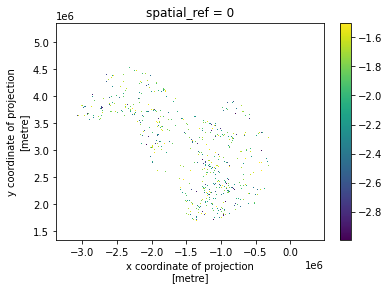

In [97]:

dlst_cold.plot()

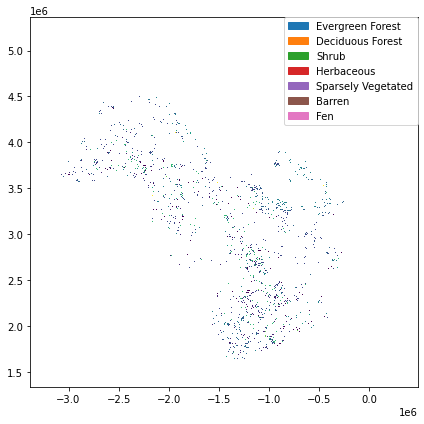

In [93]:
import matplotlib.patches as mpatches
import matplotlib.cm as cm

# data = [dlst_cold,dlcc_cold_max,dlst_hot,dlcc_hot_max]
plt.close()
# ar = 1.0  # initial aspect ratio for first trial
# wi = 18  # width of the whole figure in inches, ...
# # set it wide enough to cover all columns of sub-plots
# hi = wi * ar  # height in inches
# # set number of rows/columns
# rows, cols = 2, 2
# gs = gridspec.GridSpec(rows, cols)
# fig= plt.figure(figsize=(wi, hi))
# ax = plt.subplot(gs[0], projection=ccrs.AlbersEqualArea())
# im = data[0].plot.imshow(ax=ax,add_colorbar=False)
# cb = plt.colorbar(im, fraction=0.046, pad=0.02, shrink=0.80)
# cb.set_label(label="$\Delta LST_{LCC}$", fontsize=18)
# cb.ax.tick_params(labelsize=16)

fig= plt.figure(figsize=(6,6))
labels = {0:'Evergreen Forest',1:'Deciduous Forest ',2:'Shrub',3:'Herbaceous',
4:'Sparsely Vegetated',5:'Barren',6:"Fen"}

patches =[mpatches.Patch(color=cm.tab10(i),label=labels[i]) for i in range(7)]
# ax1 = plt.subplot(gs[1], projection=ccrs.AlbersEqualArea())
im = dlcc_cold_max.plot.imshow(add_colorbar=False)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
plt.legend(handles=patches, loc=1, borderaxespad=0.)
plt.title("", {'fontname': 'Times New Roman'}, fontsize=22),
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.savefig(out_dir+"test.png")



(array([17080., 15149., 54797., 22833., 20132.,  1477., 21087.,   822.,
          184.,   506.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

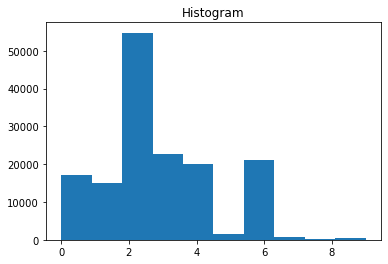

In [26]:
data = [dlst_cold,dlcc_cold_max,dlst_hot,dlcc_hot_max]
plt.close()
ar = 1.0  # initial aspect ratio for first trial
wi = 18  # width of the whole figure in inches, ...
# set it wide enough to cover all columns of sub-plots
hi = wi * ar  # height in inches
# set number of rows/columns
rows, cols = 2, 2
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(wi, hi))
for k in range(0, rows * cols):
    ax = plt.subplot(gs[k], projection=ccrs.AlbersEqualArea())
    im = data[k].plot.imshow(ax=ax,
                             ylim=ylim,
                             xlim=xlim,
                             add_colorbar=False,
                             cmap="seismic")
    cb = plt.colorbar(im, fraction=0.046, pad=0.02, shrink=0.80)
    cb.set_label(label=labels[k], fontsize=18)
    cb.ax.tick_params(labelsize=16)
    ax.set_title(titles[k], {'fontname': 'Times New Roman'}, fontsize=22),
    ax.set_ylabel("")
    ax.set_xlabel("")
plt.draw()
xmin, xmax = ax.get_xbound()
ymin, ymax = ax.get_ybound()
y2x_ratio = (ymax - ymin) / (xmax - xmin) * rows / cols
fig.set_figheight(wi * y2x_ratio)
gs.tight_layout(fig)
plt.savefig(out_dir + "FigS2_map_total_change.png")
print("all done!")
dlst_lcc_clean.to_netcdf("/data/home/hamiddashti/mnt/nasa_above/working/modis_analyses/test/dlst_lcc_clean.nc")